In [1]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [2]:
# load combined RPE_PR models
from pathlib import Path
from cobra.io import read_sbml_model

mod_RPE_PR = read_sbml_model(Path().cwd() / "models" / "mod_RPE_PR.xml")
mod_RPE_PR.id = 'RPE_PR_old'
mod_RPE_PR.name = 'RPE_PR_old'
mod_Human1_Human1 = read_sbml_model(Path().cwd() / "models" /  "mod_Human1_Human1.xml")
mod_Human1_Human1.id = 'RPE_PR_control_old'
mod_Human1_Human1.name = 'RPE_PR_control_old'
mod = read_sbml_model(Path().cwd() / 'models/Human-GEM.xml')
mod.id = 'Human1_old'
mod.name = 'Human1_old'  

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


In [3]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
import glob 
import os   

os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR/cs_mods/July2023') # set cwd
model_list = []
for file in glob.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file[:-4] # remove .xml 
    model.name = file[:-4] # remove .xml
    model_list.append(model)
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') # reset cwd

No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [4]:
# add old models to model_list
model_list = model_list + [mod,mod_RPE_PR]

# check out model_list
model_list

[<Model Human-GEM_28062023 at 0x200dc4b77f0>,
 <Model mod_RPE_PRcone_Liang at 0x20140ad28f0>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x201487cf670>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x2014aba65f0>,
 <Model mod_RPE_PRcone_Lukowski at 0x2014ecb8700>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x201565fec20>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x2015a3b7dc0>,
 <Model mod_RPE_PRcontrol at 0x2015f473610>,
 <Model mod_RPE_PRrod_Liang at 0x2017cfd7c70>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x20148224e50>,
 <Model mod_RPE_PRrod_Liang_singleRPE at 0x20185067a30>,
 <Model mod_RPE_PRrod_Lukowski at 0x201891862f0>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x20192413bb0>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x2019416bd30>,
 <Model Human1_old at 0x200c614fbe0>,
 <Model RPE_PR_old at 0x200e468d570>]

In [5]:
# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)

for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

In [6]:
# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]

# close PR exchange in combined models and open RPE exchange (efflux)
for m in combined_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,0)
    for r in [r for r in m.reactions if len(r.products) == 0 if '_RPE' in r.id]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000) 

# only allow efflux exchange in single models
for m in single_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,1000)

# for Human1 models, open efflux
for m in [m for m in model_list if 'Human' in m.id]:
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)

In [7]:
# dark new estimates
# MAR09048 = oxygen exchange
# MAR09034 = glucose exchange
# MAR09135 = lactate exchange

def set_bound(model, ex_dict): 
    """set bounds for exchange reactions in model based on dict"""
    for ex in ex_dict.keys():
        if ex + '_RPE' in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex + '_RPE').bounds = ex_dict[ex]
        elif ex + '_PR' in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex + '_PR').bounds = ex_dict[ex]
        elif ex + '_eRPE_PR' in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex + '_eRPE_PR').bounds = ex_dict[ex]
        elif ex in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex).bounds = ex_dict[ex]
        else:  
            print('no exchange reaction for ' + ex + ' in model: ' + model.id)
    return model


ex_bounds = {'MAR09048':(-3.51,1000),'MAR09034':(-4.18,1000),'MAR09135':(7.25,1000)}

for m in model_list:
    set_bound(m, ex_bounds)

import pandas as pd
results_dict = {}
for m in model_list:
    m.optimize()
    results_dict[m.id] = m.objective.value
df1 = pd.DataFrame(results_dict, index = ['max ATP hydrolysis (pmol/s/mm^2)']).T
df1


,max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,24.7325
mod_RPE_PRcone_Liang,23.9000
mod_RPE_PRcone_Liang_singlePR,11.1350
mod_RPE_PRcone_Liang_singleRPE,23.9000
mod_RPE_PRcone_Lukowski,24.7325
mod_RPE_PRcone_Lukowski_singlePR,22.2350
mod_RPE_PRcone_Lukowski_singleRPE,23.9000
mod_RPE_PRcontrol,24.7325
mod_RPE_PRrod_Liang,23.9000
mod_RPE_PRrod_Liang_singlePR,13.9100


In [109]:
# single if 'single', 'Human-GEM_28062023', or 'Human1_old' in df1.index else 'combined'
index1= ['single' if 'single' in x \
        or 'Human-GEM_28062023' in x \
        or 'Human1_old' in x \
        else 'combined' for x in list(df1.index)]

# 'Lukowski'if in df1.index, 'Liang' if in df1.index, Human1 if in df1.index else ''
index2 = ['Lukowski' if 'Lukowski' in x \
        else 'Liang' if 'Liang' in x \
        else 'none' if 'Human' or 'control' in x \
        else 'Liang' for x in list(df1.index)]

# 'cone'if ends with cone in df1.index, 'rod' if ends with PR and contains rod in df1.index, RPE if ends with RPE df1.index, Human1 if Human1 in df1.index, else 'RPE-PR
index3 = ['cone' if x.endswith('PR') and 'cone' in x \
        else 'rod' if x.endswith('PR') and 'rod' in x \
        else 'RPE' if x.endswith('RPE') \
        else 'Human1' if 'Human1_old' in x \
        else 'Human1' if 'Human-GEM_28062023' in x \
        else 'Human1-Human1' if 'control'in x \
        else 'Human1-Human1' if 'RPE_PR_old'in x
        else 'RPE-PR rod' if 'RPE_PRrod' in x\
        else 'RPE-PR cone' if 'RPE_PRcone' in x\
        else 'RPE-PR rod' for x in list(df1.index)]


x_ticks = [1 if 'Human' in x \
        else 2 if x is 'RPE' \
        else 3 if 'cone' in x \
        else 4 if 'rod' in x \
        else '' for x in index3]

index = pd.DataFrame([x_ticks,index1, index2, index3]).T

# add index as new index to df1
df2 = pd.concat([index,df1.reset_index()], axis=1)
df2.columns = ['xticks','type','PR_data','cell','model_name','max ATP hydrolysis (pmol/s/mm^2)']
df2_combined = df2[df2['type'] == 'combined']
df2_single = df2[df2['type'] == 'single']
df2




<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\prins\AppData\Local\Temp\ipykernel_22836\406377762.py:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  else 2 if x is 'RPE' \


,xticks,type,PR_data,cell,model_name,max ATP hydrolysis (pmol/s/mm^2)
0,1,single,none,Human1,Human-GEM_28062023,24.7325
1,3,combined,Liang,RPE-PR cone,mod_RPE_PRcone_Liang,23.9000
2,3,single,Liang,cone,mod_RPE_PRcone_Liang_singlePR,11.1350
3,2,single,Liang,RPE,mod_RPE_PRcone_Liang_singleRPE,23.9000
4,3,combined,Lukowski,RPE-PR cone,mod_RPE_PRcone_Lukowski,24.7325
5,3,single,Lukowski,cone,mod_RPE_PRcone_Lukowski_singlePR,22.2350
6,2,single,Lukowski,RPE,mod_RPE_PRcone_Lukowski_singleRPE,23.9000
7,1,combined,none,Human1-Human1,mod_RPE_PRcontrol,24.7325
8,4,combined,Liang,RPE-PR rod,mod_RPE_PRrod_Liang,23.9000
9,4,single,Liang,rod,mod_RPE_PRrod_Liang_singlePR,13.9100


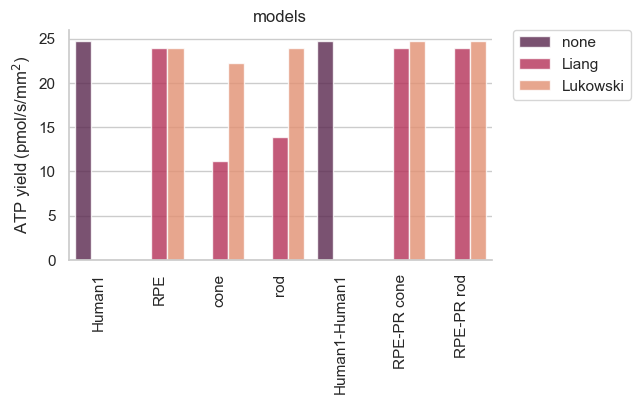

In [105]:
# plot results with seaborn catplot

# FIG
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g_all = sns.catplot(
    data=df2, kind="bar",
    x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", 
    order = ['Human1','RPE','cone','rod','Human1-Human1','RPE-PR cone','RPE-PR rod'],
     palette="rocket", alpha=.8, height=4,
)
g_all.despine(left=False)
g_all.set_axis_labels("","ATP yield (pmol/s/mm$^{2}$)")
g_all.legend.set_title("expression data")
# rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('models')

#remove one of the two legends
g_all._legend.remove()
g_all.legend.set_title("expression data")

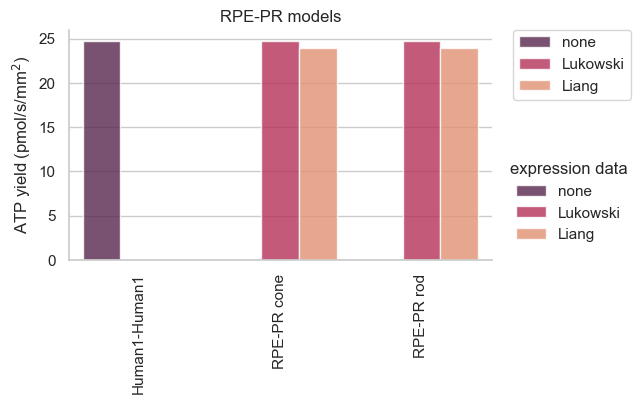

In [106]:
# plot results with seaborn catplot

# FIG
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# select only combined models
df2_combined = df2[df2['type'] == 'combined']

# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g_combined = sns.catplot(
    data=df2_combined, kind="bar",
    x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", hue_order=['none','Lukowski','Liang'],
    order = ['Human1-Human1','RPE-PR cone','RPE-PR rod'],
     palette="rocket", alpha=.8, height=4,
)
g_combined.despine(left=False)
g_combined.set_axis_labels("","ATP yield (pmol/s/mm$^{2}$)")

# rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('RPE-PR models')

#remove one of the two legends
g_combined.legend.set_title("expression data")
    

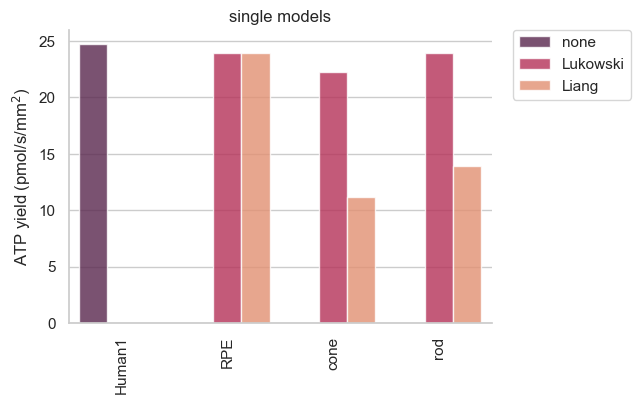

In [107]:
# plot results with seaborn catplot

# FIG
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# select only combined models
df2_single = df2[df2['type'] == 'single']

# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g_single = sns.catplot(
    data=df2_single, kind="bar",
    x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", hue_order=['none','Lukowski','Liang'],
    order = ['Human1','RPE','cone','rod'],
     palette="rocket", alpha=.8, height=4,
)
g_single.despine(left=False)
g_single.set_axis_labels("","ATP yield (pmol/s/mm$^{2}$)")

# rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('single models')

#remove one of the two legends
g_single._legend.remove()
g_single.legend.set_title("expression data")
    

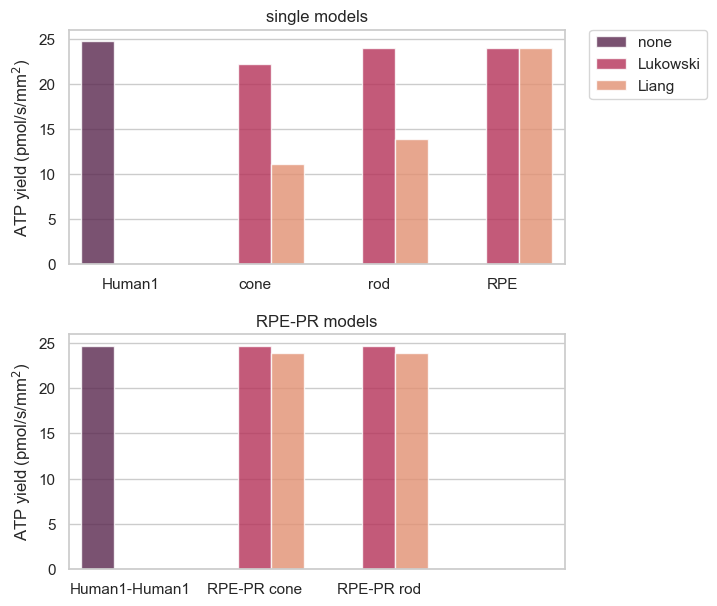

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# set up figure with two subplots
fig, axs = plt.subplots(nrows=2)    
# increase height of figure
fig.set_figheight(7)

# plot results with seaborn barplot (SINGLE MODELS)
sns.barplot(x='cell', 
            y='max ATP hydrolysis (pmol/s/mm^2)',
             data=df2_single, 
             ax=axs[0], 
             hue='PR_data',
            hue_order=['none','Lukowski','Liang'], 
            order = ['Human1','cone','rod','RPE'], 
            palette="rocket", alpha=.8, )

axs[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plot results with seaborn barplot (COMBINED MODELS)
sns.barplot(x='cell', 
            y='max ATP hydrolysis (pmol/s/mm^2)', 
            data=df2_combined, ax=axs[1], 
            hue="PR_data", 
            hue_order=['none','Lukowski','Liang'], 
            order = ['Human1-Human1','RPE-PR cone','RPE-PR rod'],
            palette="rocket", alpha=.8, )

# make bars same width for both subplots
axs[1].set_xlim(axs[0].get_xlim())

# move legend outside of plot
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# add axis titles
axs[0].set_title('single models')
axs[1].set_title('RPE-PR models')
# add y-axis label
axs[0].set_ylabel('ATP yield (pmol/s/mm$^{2}$)')
axs[1].set_ylabel('ATP yield (pmol/s/mm$^{2}$)')
# remove x-axis label
axs[0].set_xlabel('')
axs[1].set_xlabel('')
#increase space between subplots
plt.subplots_adjust(hspace=0.3)
# remove one of the two legends using  get_legend().remove()
axs[1].get_legend().remove()


In [134]:
# sampling of the flux space
from cobra.sampling import sample

# sample flux space of combined models
print(single_models[0].id)
# empty dict to store results
results_dict = {}
for m in [single_models[0]]:
    s = sample(m, 10)
    s.head()
    # record results in dict
    results_dict[m.id] = s

# convert dict to dataframe
df_sampling_results = pd.concat(results_dict, axis=1)
df_sampling_results


mod_RPE_PRcone_Liang_singlePR
Read LP format model from file C:\Users\prins\AppData\Local\Temp\tmpmb1tokpd.lp
Reading time = 0.02 seconds
: 5053 rows, 12828 columns, 48114 nonzeros


mod_RPE_PRcone_Liang_singlePR                                    \
               MAR03989_eRPE_PR MAR04303_eRPE_PR MAR04416_eRPE_PR   
0                           0.0              0.0     1.017774e-20   
1                           0.0              0.0     1.017843e-20   
2                           0.0              0.0     9.968294e-21   
3                           0.0              0.0     9.776344e-21   
4                           0.0              0.0     9.853822e-21   
5                           0.0              0.0     2.117704e-20   
6                           0.0              0.0     9.782368e-21   
7                           0.0              0.0     9.351788e-21   
8                           0.0              0.0     9.334361e-21   
9                           0.0              0.0     9.326698e-21   

                                                                       \
  MAR04081_eRPE_PR MAR04086_eRPE_PR MAR04450_eRPE_PR MAR06603_eRPE_PR   
0    -1.846706e-19    -1.846706e-19              0.0     1.369604e-18   
1    -1.846830e-19    -1.846830e-19              0.0     1.369613e-18   
2    -1.808702e-19    -1.808702e-19              0.0     1.366641e-18   
3    -1.773874e-19    -1.773874e-19              0.0     1.363874e-18   
4    -1.787932e-19    -1.787932e-19              0.0     1.365002e-18   
5    -3.842478e-19    -3.842478e-19              0.0     1.533285e-18   
6    -1.774967e-19    -1.774967e-19              0.0     1.363724e-18   
7    -1.696840e-19    -1.696840e-19              0.0     4.072081e-15   
8    -1.693678e-19    -1.693678e-19              0.0     4.072043e-15   
9    -1.692287e-19    -1.692287e-19              0.0     4.071878e-15   

                                                      ...              \
  MAR04179_eRPE_PR MAR04136_eRPE_PR MAR04422_eRPE_PR  ... MAR10065_PR   
0              0.0              0.0              0.0  ...         0.0   
1              0.0              0.0              0.0  ...         0.0   
2              0.0              0.0              0.0  ...         0.0   
3              0.0              0.0              0.0  ...         0.0   
4              0.0              0.0              0.0  ...         0.0   
5              0.0              0.0              0.0  ...         0.0   
6              0.0              0.0              0.0  ...         0.0   
7              0.0              0.0              0.0  ...         0.0   
8              0.0              0.0              0.0  ...         0.0   
9              0.0              0.0              0.0  ...         0.0   

                                                                             \
  MAR10067_PR MAR10068_PR   MAR13083_PR MAR13087_PR MAR20044_PR MAR20070_PR   
0         0.0         0.0 -3.690510e-17         0.0    0.879866    0.000275   
1         0.0         0.0 -3.690517e-17         0.0    0.879017    0.000275   
2         0.0         0.0 -3.709527e-17         0.0    0.939138    0.000275   
3         0.0         0.0 -3.818826e-17         0.0    1.022735    0.000274   
4         0.0         0.0 -3.962304e-17         0.0    1.685571    0.000274   
5         0.0         0.0 -4.136180e-17         0.0   14.080322    0.000278   
6         0.0         0.0 -3.960531e-17         0.0   29.572204    0.000274   
7         0.0         0.0 -4.157642e-14         0.0   29.339533    0.000274   
8         0.0         0.0 -4.157604e-14         0.0   30.810361    0.000190   
9         0.0         0.0 -4.147723e-14         0.0   33.616710    0.000190   

                                         
  MAR20089_PR   MAR20110_PR MAR03964_PR  
0         0.0  5.454366e-18    0.242081  
1         0.0  5.621435e-18    0.241995  
2         0.0  5.552853e-18    0.241890  
3         0.0  8.496643e-18    0.242088  
4         0.0  8.522025e-18    0.234335  
5         0.0  1.224639e-17    0.280802  
6         0.0  8.497587e-18    0.272431  
7         0.0  2.312735e-16    0.253318  
8         0.0  2.312656e-16    0.241679  
9       

In [155]:
# remove first layer of multiindex
df_results = df_sampling_results.copy()
df_results.columns = df_results.columns.droplevel(0)
df_results

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

In [176]:
# make reaction dataframe
from src.get_info import make_rxn_df
rxns=make_rxn_df(single_models[0])
# merge rxns and df_results.T vertically, match index
df_results_rxns = rxns.merge(df_results.T, left_index=True, right_index=True)

df_results_rxns


,cell,lb,ub,tcdb,vmhreaction,kegg.reaction,sbo,rhea,ec-code,metanetx.reaction,...,0,1,2,3,4,5,6,7,8,9
MAR03989_eRPE_PR,PR,0.0,1000.0,,MALTe,R00028,SBO:0000176,68796,3.2.1.20,MNXR101350,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
MAR04303_eRPE_PR,PR,0.0,1000.0,,SUCRe,R00801,SBO:0000176,,"[3.2.1.10, 3.2.1.20, 3.2.1.48]",MNXR104638,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
MAR04416_eRPE_PR,PR,0.0,1000.0,,r0627,R01104,SBO:0000176,,"[3.2.1.22, 3.2.1.23]",MNXR100115,...,1.017774e-20,1.017843e-20,9.968294e-21,9.776344e-21,9.853822e-21,2.117704e-20,9.782368e-21,9.351788e-21,9.334361e-21,9.326698e-21
MAR04081_eRPE_PR,PR,0.0,1000.0,,NTD7e,R00183,SBO:0000176,"[29376, 29375]",3.1.3.5,MNXR102037,...,-1.846706e-19,-1.846830e-19,-1.808702e-19,-1.773874e-19,-1.787932e-19,-3.842478e-19,-1.774967e-19,-1.696840e-19,-1.693678e-19,-1.692287e-19
MAR04086_eRPE_PR,PR,0.0,1000.0,,r0051,R00190,SBO:0000176,"[16612, 16609]",2.4.2.7,MNXR95482,...,-1.846706e-19,-1.846830e-19,-1.808702e-19,-1.773874e-19,-1.787932e-19,-3.842478e-19,-1.774967e-19,-1.696840e-19,-1.693678e-19,-1.692287e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20044_PR,PR,0.0,1000.0,,,R07140,SBO:0000176,19981,1.1.1.284,MNXR110840,...,8.798659e-01,8.790170e-01,9.391380e-01,1.022735e+00,1.685571e+00,1.408032e+01,2.957220e+01,2.933953e+01,3.081036e+01,3.361671e+01
MAR20070_PR,PR,0.0,1000.0,,,,SBO:0000176,,3.1.3.11,,...,2.745491e-04,2.745491e-04,2.745155e-04,2.744730e-04,2.744926e-04,2.781185e-04,2.744216e-04,2.742561e-04,1.904579e-04,1.904473e-04
MAR20089_PR,PR,0.0,1000.0,,,R02701,SBO:0000176,18533,4.1.1.28,MNXR151808,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
MAR20110_PR,PR,0.0,1000.0,,,,SBO:0000176,"[15642, 15641]",,MNXR102097,...,5.454366e-18,5.621435e-18,5.552853e-18,8.496643e-18,8.522025e-18,1.224639e-17,8.497587e-18,2.312735e-16,2.312656e-16,2.556976e-15


In [182]:
# do loopless flux variability analysis on single_models[0]
from cobra.flux_analysis import flux_variability_analysis
fva = flux_variability_analysis(single_models[0], fraction_of_optimum=0.9, loopless=True)
fva

In [158]:
# add fva results to df_results_rxns
df_results_rxns_fva = df_results_rxns.merge(fva, left_index=True, right_index=True)
df_results_rxns_fva

,cell,lb,ub,tcdb,vmhreaction,kegg.reaction,sbo,rhea,ec-code,metanetx.reaction,...,2,3,4,5,6,7,8,9,minimum,maximum
MAR03989_eRPE_PR,PR,0.0,1000.0,,MALTe,R00028,SBO:0000176,68796,3.2.1.20,MNXR101350,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000
MAR04303_eRPE_PR,PR,0.0,1000.0,,SUCRe,R00801,SBO:0000176,,"[3.2.1.10, 3.2.1.20, 3.2.1.48]",MNXR104638,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000
MAR04416_eRPE_PR,PR,0.0,1000.0,,r0627,R01104,SBO:0000176,,"[3.2.1.22, 3.2.1.23]",MNXR100115,...,9.968294e-21,9.776344e-21,9.853822e-21,2.117704e-20,9.782368e-21,9.351788e-21,9.334361e-21,9.326698e-21,0.0000,0.0000
MAR04081_eRPE_PR,PR,0.0,1000.0,,NTD7e,R00183,SBO:0000176,"[29376, 29375]",3.1.3.5,MNXR102037,...,-1.808702e-19,-1.773874e-19,-1.787932e-19,-3.842478e-19,-1.774967e-19,-1.696840e-19,-1.693678e-19,-1.692287e-19,0.0000,0.0000
MAR04086_eRPE_PR,PR,0.0,1000.0,,r0051,R00190,SBO:0000176,"[16612, 16609]",2.4.2.7,MNXR95482,...,-1.808702e-19,-1.773874e-19,-1.787932e-19,-3.842478e-19,-1.774967e-19,-1.696840e-19,-1.693678e-19,-1.692287e-19,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20044_PR,PR,0.0,1000.0,,,R07140,SBO:0000176,19981,1.1.1.284,MNXR110840,...,9.391380e-01,1.022735e+00,1.685571e+00,1.408032e+01,2.957220e+01,2.933953e+01,3.081036e+01,3.361671e+01,0.0000,1000.0000
MAR20070_PR,PR,0.0,1000.0,,,,SBO:0000176,,3.1.3.11,,...,2.745155e-04,2.744730e-04,2.744926e-04,2.781185e-04,2.744216e-04,2.742561e-04,1.904579e-04,1.904473e-04,0.0000,1.1135
MAR20089_PR,PR,0.0,1000.0,,,R02701,SBO:0000176,18533,4.1.1.28,MNXR151808,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000
MAR20110_PR,PR,0.0,1000.0,,,,SBO:0000176,"[15642, 15641]",,MNXR102097,...,5.552853e-18,8.496643e-18,8.522025e-18,1.224639e-17,8.497587e-18,2.312735e-16,2.312656e-16,2.556976e-15,0.0000,0.0000


In [167]:
# pull out index ids MAR06916 amd MAR04358
oxphos_glycolysis = df_results_rxns_fva.loc[['MAR06916_PR', 'MAR04358_PR']]
oxphos_glycolysis

,cell,lb,ub,tcdb,vmhreaction,kegg.reaction,sbo,rhea,ec-code,metanetx.reaction,...,2,3,4,5,6,7,8,9,minimum,maximum
MAR06916_PR,PR,0.0,1000.0,,ATPS4mi,R00086,SBO:0000185,13065,"[3.6.1.3, 3.6.1.5, 3.6.3.1, 3.6.3.10, 3.6.3.14...","[MNXR96131, MNXR96136]",...,0.043850,0.044046,0.045457,0.059980,0.111059,0.115890,0.120923,0.145333,1.6615,3.146167
MAR04358_PR,PR,0.0,1000.0,,PYK,R00200,SBO:0000176,"[18159, 18157]",2.7.1.40,MNXR103371,...,952.944314,952.863653,951.966901,964.058604,953.696867,953.585857,952.118783,953.397315,0.0000,1000.000000


<AxesSubplot: xlabel='subsystem', ylabel='minimum'>

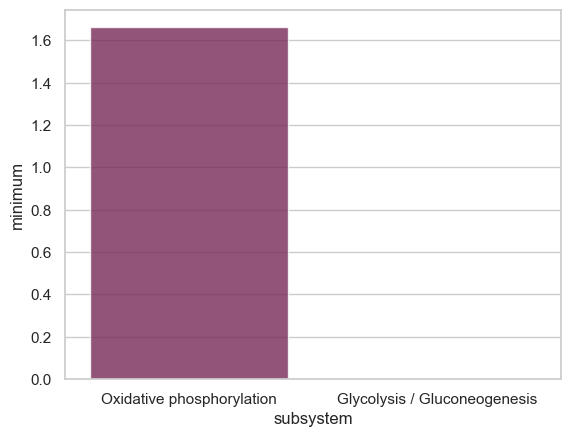

In [ ]:
# plot oxphos glycolysis columns ['minimum', 'maximum'] on a log scale
import numpy as np
import matplotlib.pyplot as plt
# barplot sns
sns.set_theme(style="whitegrid")
sns.barplot(x='subsystem',
            y=oxphos_glycolysis['minimum', 'maximum'],
            data=oxphos_glycolysis,
            palette="rocket", alpha=.8, )
# log scale y-axis
plt.yscale('log')


In [124]:
# sampling of the flux space
from cobra.sampling import sample

# sample flux space of combined models

# empty dict to store results
results_dict = {}
for m in combined_models:
    s = sample(m, 100)
    s.head()
    # record results in dict
    results_dict[m.id] = s

# convert dict to dataframe
df_sampling_results = pd.concat(results_dict, axis=1)
df_sampling_results


Read LP format model from file C:\Users\prins\AppData\Local\Temp\tmps9ew3bnk.lp
Reading time = 0.05 seconds
: 8499 rows, 26170 columns, 112108 nonzeros


KeyboardInterrupt: 

In [ ]:

( x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", hue_order=['none','Lukowski','Liang'],
    order = ['Human1','RPE','cone','rod'],
     palette="rocket", alpha=.8,axs=axs[0], data=df2_single)

In [13]:
# get model from list with particular id
def get_mod_by_id(item_list, id):
    for item in item_list:
        if item.id == id:
            return item
m = get_mod_by_id(model_list, 'Human-GEM_28062023')

from src.get_info import make_rxn_df

rxns=make_rxn_df(m)
rxns.to_clipboard()
rxns

,cell,lb,ub,tcdb,vmhreaction,kegg.reaction,sbo,rhea,ec-code,metanetx.reaction,reactome,bigg.reaction,name,subsystem,reaction,met_IDs,GPR
MAR03905,None,0.0,1000.0,,ALCD2if,R00754,SBO:0000176,"[25291, 25290]","[1.1.1.1, 1.1.1.71]",MNXR95725,,ALCD2x,ethanol:NAD+ oxidoreductase,Glycolysis / Gluconeogenesis,ethanol[c] + NAD+[c] --> acetaldehyde[c] + H+[...,MAM01796c + MAM02552c --> MAM01249c + MAM02039...,ENSG00000147576 or ENSG00000172955 or ENSG0000...
MAR03907,None,0.0,1000.0,,ALCD2yf,R00746,SBO:0000176,,1.1.1.2,MNXR95726,,ALCD2y,Ethanol:NADP+ oxidoreductase,Glycolysis / Gluconeogenesis,ethanol[c] + NADP+[c] --> acetaldehyde[c] + H+...,MAM01796c + MAM02554c --> MAM01249c + MAM02039...,ENSG00000117448
MAR04097,None,0.0,1000.0,,ACS,R00235,SBO:0000176,"[23177, 23176]",6.2.1.1,MNXR95413,,ACS,Acetate:CoA ligase (AMP-forming),Glycolysis / Gluconeogenesis,acetate[c] + ATP[c] + CoA[c] --> acetyl-CoA[c]...,MAM01252c + MAM01371c + MAM01597c --> MAM01261...,ENSG00000131069
MAR04099,None,0.0,1000.0,,ACSm,R00235,SBO:0000176,"[23177, 23176]",6.2.1.1,MNXR95413,,ACSm,Acetate:CoA ligase (AMP-forming),Glycolysis / Gluconeogenesis,acetate[m] + ATP[m] + CoA[m] --> acetyl-CoA[m]...,MAM01252m + MAM01371m + MAM01597m --> MAM01261...,ENSG00000111058 or ENSG00000154930
MAR04108,None,0.0,1000.0,,r0068,R00236,SBO:0000176,,6.2.1.1,MNXR105304,,,acetyl adenylate:CoA acetyltransferase,Glycolysis / Gluconeogenesis,acetyl adenylate[c] + CoA[c] --> acetyl-CoA[c]...,MAM01257c + MAM01597c --> MAM01261c + MAM01334...,ENSG00000131069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20107,None,0.0,1000.0,,,,SBO:0000176,44564,2.5.1.39,MNXR100567,,"[HBZOPT10m, R_HBZOPT10m]",MAR20107,Ubiquinone and other terpenoid-quinone biosynt...,4-hydroxybenzoate[r] + all-trans-decaprenyl-di...,MAM00995r + MAM01316r --> MAM00767r + MAM02759r,ENSG00000120942
MAR20108,None,0.0,1000.0,,,,SBO:0000176,44564,2.5.1.39,MNXR100567,,"[HBZOPT10m, R_HBZOPT10m]",MAR20108,Ubiquinone and other terpenoid-quinone biosynt...,4-hydroxybenzoate[g] + all-trans-decaprenyl-di...,MAM00995g + MAM01316g --> MAM00767g + MAM02759g,ENSG00000120942
MAR20109,None,0.0,1000.0,,,,SBO:0000176,44564,2.5.1.39,MNXR100567,,"[HBZOPT10m, R_HBZOPT10m]",MAR20109,Ubiquinone and other terpenoid-quinone biosynt...,4-hydroxybenzoate[n] + all-trans-decaprenyl-di...,MAM00995n + MAM01316n --> MAM00767n + MAM02759n,ENSG00000120942
MAR20110,None,0.0,1000.0,,,,SBO:0000176,"[15642, 15641]",,MNXR102097,,,MAR20110,Miscellaneous,H+[m] + OAA[m] --> CO2[m] + pyruvate[m],MAM02039m + MAM02633m --> MAM01596m + MAM02819m,ENSG00000180185


In [14]:
m.reactions.get_by_id('MAR03964')


Reaction identifier,MAR03964
Name,ATP phosphohydrolase
Memory address,0x2013cef8bb0
Stoichiometry,MAM01371c + MAM02040c --> MAM01285c + MAM02039c + MAM02751c ATP + H2O --> ADP + H+ + Pi
GPR,
Lower bound,0.0
Upper bound,1000.0


In [15]:

for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

In [16]:
def fba_analysis(mod, boundary_dicts, boundary_labels=dict(),results_name=''):    
    # inputs: model, list of boundary dicts {rxnID:(lb,ub)}, objective function rxnID (string)
    import pandas as pd
    from datetime import datetime
    from src.get_info import make_rxn_df, make_compact_rxn_df
    from datetime import datetime

    #  create empty dicts
    bounds = dict() # changed model bounds
    conditions = dict()
    ovs = dict() # objective values
    f = dict() # fba fluxes
    uptake = dict() # uptake fluxes
    secretion = dict() # secretion fluxes
        
    #   set counter, i, to 1
    i = 0
        
    with mod as m:
            
        # run analysis for every dict in list
        for d in boundary_dicts:
            for k in d:   # set bounds for all keys (rxnIDs in dict)
                m.reactions.get_by_id(k).bounds = d[k] # set bounds defined in dict

            # run analysis
            fba = m.optimize() # fba
            
            # objective values
            ovs[i] = [m.objective, m.objective.direction, fba.objective_value]
            
            if fba.status == 'optimal':

                # write analysis info / results into dicts

                # uptake / secretion
                uptake_summary = m.summary().uptake_flux
                secretion_summary = m.summary().secretion_flux
                uptake[i] = pd.DataFrame(uptake_summary['flux'])
                secretion[i] = pd.DataFrame(secretion_summary['flux'])
                
                # all fluxes
                f[i] = fba.to_frame()['fluxes']
          
            # update counter
            i=i+1
    
    # prepare dfs for excel sheet
    model_info = pd.DataFrame([m.id, m.name,m.compartments,m.annotation],\
             index=['id','name','compartments','annotation'],columns = ['model'])
    
    rxn_df = make_rxn_df(m)   
    compact_rxn_df = make_compact_rxn_df(m)  
    
    met_df = pd.DataFrame([[mi.name,mi.compartment,mi.formula,mi.charge,[r.id for r in list(mi.reactions)]] for mi in m.metabolites],\
             index=[m.id for m in m.metabolites],columns=['name','compartment','formula','charge','reactions'])
    
    ovs_df  = pd.concat([pd.DataFrame(boundary_dicts),\
                         pd.DataFrame(boundary_labels),\
                          pd.DataFrame(ovs, index=['objective','objective_direction','objective_value']).T],axis=1)
    
    # uptake / secretion dfs

    uptake_df = pd.concat(uptake,axis=1)
    secretion_df = pd.concat(secretion,axis=1)
    
    secretion_mets = pd.DataFrame([[met.name for met in m.reactions.get_by_id(mets).reactants] \
                                for mets in secretion_df.index],\
                               columns=['metabolite'],index= secretion_df.index)
    uptake_mets = pd.DataFrame([[met.name for met in m.reactions.get_by_id(mets).reactants] \
                                for mets in uptake_df.index],\
                               columns=['metabolite'],index= uptake_df.index)
    
    uptake_df = pd.merge(secretion_mets, uptake_df, left_index=True, right_index=True)  
    secretion_df = pd.merge(secretion_mets, secretion_df, left_index=True, right_index=True)  
                                     
    # sort uptake / secretion dfs
    uptake_df = uptake_df.reindex(uptake_df.fillna(0).sort_values(by=[c for c in secretion_df.columns if 'flux' in c],ascending=False).index)
    secretion_df = secretion_df.reindex(secretion_df.fillna(0).sort_values(by=[c for c in secretion_df.columns if 'flux' in c],ascending=True).index)
    
    # fluxes df
    fluxes_df = pd.concat([pd.DataFrame(f)],keys=["flux"],axis=1)
    fluxes_df = fluxes_df =pd.merge(compact_rxn_df, fluxes_df,left_index=True, right_index=True)
    # sort table on absolute flux size 
    fluxes_df= fluxes_df.reindex(fluxes_df[[c for c in fluxes_df.columns if 'flux' in c]].abs().sort_values(by=[c for c in fluxes_df.columns if 'flux' in c],ascending=False).index)
    fluxes_df[fluxes_df.index.isin([r.id for r in m.reactions if len(r.products)>0])]
    # select internal fluces only
    fluxes_df[fluxes_df.index.isin([r.id for r in m.reactions if len(r.products)>0])]
        
    # date stamp
    datestr = datetime.strftime(datetime.now(), '%H%M_%d-%m-%Y')   
    
    # write excel file
    with pd.ExcelWriter('fba_analysis_' + results_name + '_' + datestr + '.xlsx') as writer:  
        model_info.to_excel(writer, sheet_name = 'model')
        rxn_df.to_excel(writer, sheet_name = 'reactions')
        met_df.to_excel(writer, sheet_name = 'metabolites')
        ovs_df.to_excel(writer, sheet_name = 'objective_values')  
        uptake_df.to_excel(writer, sheet_name = 'uptake')    
        secretion_df.to_excel(writer, sheet_name = 'secretion')    
        fluxes_df.to_excel(writer, sheet_name = 'fluxes')     
        
    return [ovs_df, uptake_df, secretion_df, fluxes_df]

In [17]:
# modify models
# load blood exchange bounds
import pandas as pd
df = pd.read_excel(Path().cwd() / 'rxn_bounds/blood_selection.xlsx') # with col names 'id' 'lb' 'ub'

# set bounds for blood exchange reactions
blood_ratio = {df['id'][i]:df['ratio [glucose]/[x]'] [i] for i in range(len(df['id']))}
glucose_level = -2.622342019
# blood_ratio.update((x, y*glucose_level) for x, y in blood_ratio.items())
blood_ratio

{'MAR09034_RPE': 1.0,
 'MAR09063_RPE': 0.12618432385874245,
 'MAR09061_RPE': 0.090869939707149,
 'MAR09067_RPE': 0.05555555555555555,
 'MAR09041_RPE': 0.050818260120585705,
 'MAR09046_RPE': 0.05017226528854436,
 'MAR09068_RPE': 0.0409130060292851,
 'MAR09044_RPE': 0.03574504737295435,
 'MAR09069_RPE': 0.03229974160206718,
 'MAR09040_RPE': 0.026485788113695088,
 'MAR09038_RPE': 0.023040482342807925,
 'MAR09066_RPE': 0.017226528854435832,
 'MAR09064_RPE': 0.016731266149870805,
 'MAR09043_RPE': 0.01309216192937123,
 'MAR09065_RPE': 0.01119724375538329,
 'MAR09045_RPE': 0.009474590869939707,
 'MAR09071_RPE': 0.009323858742463394,
 'MAR09062_RPE': 0.008828596037898364,
 'MAR09042_RPE': 0.005383290267011197,
 'MAR09070_RPE': 0.0032730404823428077,
 'MAR11961_RPE': 0.00014857881136950905,
 'MAR09039_RPE': 0.014233419465977604}

In [18]:
def open_blood_exchange(mod,br, glucose_level):  

    """
    Parameters
    ----------
    mod : cobra model
        model to be modified
    br : dict
        dictionary with blood exchange reaction ids as keys and fluxes as values
    glucose_level : float
        glucose level in blood

    Returns
    ------- 
    None
    """
    br_updated = br.copy()
    br_updated.update((x, y * glucose_level) for x, y in br_updated.items())
    for key in br:
        mod.reactions.get_by_id(key).bounds = (br_updated[key],1000)# allow influx for RPE exchange reactions (blood exchange)
        
def close_blood_exchange(mod,br):  
    """
    Parameters
    ----------
    mod : cobra model
        model to be modified
    br : dict
        dictionary with blood exchange reaction ids as keys and fluxes as values
    """
    for key in br:
        mod.reactions.get_by_id(key).bounds = (0,1000)# allow influx for RPE exchange reactions (blood exchange)

In [19]:
model_list[6]


Name,mod_RPE_PRcone_Lukowski_singleRPE
Memory address,2015a3b7dc0
Number of metabolites,7186
Number of reactions,9825
Number of genes,2206
Number of groups,149
Objective expression,1.0*MAR03964_RPE - 1.0*MAR03964_RPE_reverse_dc7af
Compartments,"c_RPE, r_RPE, e_RPE, m_RPE, x_RPE, g_RPE, l_RPE, n_RPE, i_RPE, e_RPE_PR"


In [20]:
from src.get_info import make_rxn_df
# make df with rxns in model
rxns = make_rxn_df(model_list[4])
rxns.to_clipboard()
rxns

,cell,lb,ub,tcdb,vmhreaction,kegg.reaction,sbo,rhea,ec-code,metanetx.reaction,reactome,bigg.reaction,name,subsystem,reaction,met_IDs,GPR
MAR03905_RPE,RPE,0.0,1000.0,,ALCD2if,R00754,SBO:0000176,"[25291, 25290]","[1.1.1.1, 1.1.1.71]",MNXR95725,,ALCD2x,ethanol:NAD+ oxidoreductase,Glycolysis / Gluconeogenesis,ethanol[c_RPE] + NAD+[c_RPE] --> acetaldehyde[...,MAM01796c_RPE + MAM02552c_RPE --> MAM01249c_RP...,ENSG00000147576 or ENSG00000172955 or ENSG0000...
MAR03907_RPE,RPE,0.0,1000.0,,ALCD2yf,R00746,SBO:0000176,,1.1.1.2,MNXR95726,,ALCD2y,Ethanol:NADP+ oxidoreductase,Glycolysis / Gluconeogenesis,ethanol[c_RPE] + NADP+[c_RPE] --> acetaldehyde...,MAM01796c_RPE + MAM02554c_RPE --> MAM01249c_RP...,ENSG00000117448
MAR04281_RPE,RPE,-1000.0,1000.0,,r0173,R00703,SBO:0000176,23444,1.1.1.27,MNXR101040,,,(S)-Lactate:NAD+ oxidoreductase,Glycolysis / Gluconeogenesis,H+[x_RPE] + NADH[x_RPE] + pyruvate[x_RPE] <=> ...,MAM02039x_RPE + MAM02553x_RPE + MAM02819x_RPE ...,ENSG00000111716 or ENSG00000134333
MAR04388_RPE,RPE,-1000.0,1000.0,,LDH_L,R00703,SBO:0000176,23444,1.1.1.27,MNXR101040,,LDH_L,(S)-Lactate:NAD+ oxidoreductase,Glycolysis / Gluconeogenesis,H+[c_RPE] + NADH[c_RPE] + pyruvate[c_RPE] <=> ...,MAM02039c_RPE + MAM02553c_RPE + MAM02819c_RPE ...,ENSG00000111716 or ENSG00000134333 or ENSG0000...
MAR04283_RPE,RPE,0.0,1000.0,,ALDD2y,R00711,SBO:0000176,"[25299, 25298]",1.2.1.5,MNXR95750,,,Acetaldehyde:NADP+ oxidoreductase,Glycolysis / Gluconeogenesis,acetaldehyde[c_RPE] + H2O[c_RPE] + NADP+[c_RPE...,MAM01249c_RPE + MAM02040c_RPE + MAM02554c_RPE ...,ENSG00000006534 or ENSG00000108602 or ENSG0000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR13087_PR,PR,0.0,1000.0,,,R02243,SBO:0000176,"[15254, 15253]",4.1.1.6,MNXR107402,,,,C5-branched dibasic acid metabolism,cis-aconitate[m_PR] + H+[m_PR] --> CO2[m_PR] +...,MAM01580m_PR + MAM02039m_PR --> MAM01596m_PR +...,ENSG00000102794
MAR20044_PR,PR,0.0,1000.0,,,R07140,SBO:0000176,19981,1.1.1.284,MNXR110840,,,MAR20044,Isolated,hydroxymethylglutathione[c_PR] + NADP+[c_PR] -...,MAM02152c_PR + MAM02554c_PR --> MAM01837c_PR +...,ENSG00000197894
MAR20069_PR,PR,0.0,1000.0,,,,SBO:0000176,,,,,,MAR20069,Glycolysis / Gluconeogenesis,2-(alpha-hydroxyethyl)thiamine-diphosphate[m_P...,MAM00561m_PR + MAM02393m_PR --> MAM02869m_PR +...,(ENSG00000131828 and ENSG00000168291 and ENSG0...
MAR20070_PR,PR,0.0,1000.0,,,,SBO:0000176,,3.1.3.11,,,,MAR20070,Pentose Phosphate Pathway,"H2O[c_PR] + sedoheptulose-1,7-bisphosphate[c_P...",MAM02040c_PR + MAM02883c_PR --> MAM02751c_PR +...,ENSG00000130957 or ENSG00000165140


In [21]:
# set objective function (ATP hydrolysis in PR for combined models)

for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)


In [22]:
# modify combined models (blood exchange)
for m in [mod_RPE_PR, mod_Human1_Human1]:
    m.objective = 'MAR03964_PR' # ATP demand in PR
    m.remove_reactions([r.id for r in  m.reactions if len(r.products)==0 if 'PR' in r.id]) # remove PR exchange reactions
    m.remove_metabolites([m for m in m.metabolites if len(m.reactions) == 0])              # prune metabolites that are unused
    for r in [r for r in m.reactions if len(r.products) == 0 if '_RPE' in r.id]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000) # close all exchange reactions
    open_blood_exchange(m,blood_ratio,glucose_level)# allow influx for RPE exchange reactions (blood exchange)

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\core\group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [23]:
# modify single models (blood exchange)
for m in [mod_RPE_PR, mod_Human1_Human1]:
    m.objective = 'MAR03964' # ATP demand in PR
    open_blood_exchange(m,blood_ratio,glucose_level)# allow influx for RPE exchange reactions (blood exchange)

ValueError: invalid objective

In [ ]:
from src.analysis import create_permutation_dicts
# MAR09048_RPE = oxygen exchange
# MAR09034_RPE = glucose exchange
# MAR09135_RPE = lactate exchange
# MAR04896_PR_RPE =  O2[c_PR] <=> O2[e_RPE_PR]

dark_old_labels = create_permutation_dicts({'oxygen':['limited oxygen (2.2)'],\
                      'glucose':['limited glucose (2.6)'],\
                      'lactate':['lactate efflux > 4.53'],\
                      'oxygen RPE -> PR':['fixed (1.9)','unlimited']})
dark_old_estimates = create_permutation_dicts({'MAR09048_RPE':[(-2.2,1000)],\
                      'MAR09034_RPE':[(-2.62,1000)],\
                      'MAR09135_RPE':[(4.53,1000)],\
                      'MAR04896_PR_RPE':[(-1.9,-1.9),(-1000,1000)]})

dark_new_labels = create_permutation_dicts({'oxygen':['limited oxygen (3.51)'],\
                      'glucose':['limited glucose (4.18)'],\
                      'lactate':[ 'lactate efflux > 7.25'],\
                      'oxygen RPE -> PR':['fixed (3.21)','unlimited']})
dark_new_estimates = create_permutation_dicts({'MAR09048_RPE':[(-3.51,1000)],\
                      'MAR09034_RPE':[(-4.18,1000)],\
                      'MAR09135_RPE':[(7.25,1000)],\
                      'MAR04896_PR_RPE':[(-3.21,-3.21),(-1000,1000)]})

light_old_labels = create_permutation_dicts({'oxygen':['limited oxygen (1.84)'],\
                      'glucose':['limited glucose (1.37)'],\
                      'lactate':['lactate efflux > 2.81'],\
                      'oxygen RPE -> PR':['fixed (1.59)','unlimited']})
light_old_estimates = create_permutation_dicts({'MAR09048_RPE':[(-1.84,1000)],\
                      'MAR09034_RPE':[ (-1.37,1000)],\
                      'MAR09135_RPE':[ (2.81,1000)],\
                      'MAR04896_PR_RPE':[(-1.59,-1.59),(-1000,1000)]})

light_new_labels = create_permutation_dicts({'oxygen':['limited oxygen (2.61)'],\
                      'glucose':['limited glucose (1.93)'],\
                      'lactate':['lactate efflux > 2.95'],\
                      'oxygen RPE -> PR':['fixed (2.31)','unlimited']})
light_new_estimates = create_permutation_dicts({'MAR09048_RPE':[(-2.61,1000)],\
                      'MAR09034_RPE':[ (-1.93,1000)],\
                      'MAR09135_RPE':[ (2.95,1000)],\
                      'MAR04896_PR_RPE':[(-2.31,-2.31),(-1000,1000)]})

In [ ]:
# FVA



In [ ]:
# SAMPLE